# Import Libraries 

In [71]:
import os
sns.set(style="whitegrid")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Load Data

In [72]:
df = pd.read_csv("covid_19_clean_complete.csv")
df.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.15330,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.03390,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.50630,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.20270,17.873900,2020-01-22,0,0,0,0,Africa


In [73]:
df.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', 'Date', 'Confirmed',
       'Deaths', 'Recovered', 'Active', 'WHO Region'],
      dtype='object')

In [74]:
df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
49063    False
49064    False
49065    False
49066    False
49067    False
Length: 49068, dtype: bool

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49068 entries, 0 to 49067
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  14664 non-null  object 
 1   Country/Region  49068 non-null  object 
 2   Lat             49068 non-null  float64
 3   Long            49068 non-null  float64
 4   Date            49068 non-null  object 
 5   Confirmed       49068 non-null  int64  
 6   Deaths          49068 non-null  int64  
 7   Recovered       49068 non-null  int64  
 8   Active          49068 non-null  int64  
 9   WHO Region      49068 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 3.7+ MB


In [76]:
df.isnull().sum()

Province/State    34404
Country/Region        0
Lat                   0
Long                  0
Date                  0
Confirmed             0
Deaths                0
Recovered             0
Active                0
WHO Region            0
dtype: int64

In [77]:
df.drop(columns=['Province/State'], inplace=True) # we are taking country in acount

In [78]:
df.shape

(49068, 9)

In [79]:
df.describe()

,Lat,Long,Confirmed,Deaths,Recovered,Active
count,49068.000000,49068.000000,4.906800e+04,49068.000000,4.906800e+04,4.906800e+04
mean,21.433730,23.528236,1.688490e+04,884.179160,7.915713e+03,8.085012e+03
std,24.950320,70.442740,1.273002e+05,6313.584411,5.480092e+04,7.625890e+04
min,-51.796300,-135.000000,0.000000e+00,0.000000,0.000000e+00,-1.400000e+01
25%,7.873054,-15.310100,4.000000e+00,0.000000,0.000000e+00,0.000000e+00
50%,23.634500,21.745300,1.680000e+02,2.000000,2.900000e+01,2.600000e+01
75%,41.204380,80.771797,1.518250e+03,30.000000,6.660000e+02,6.060000e+02
max,71.706900,178.065000,4.290259e+06,148011.000000,1.846641e+06,2.816444e+06


# Data understanding & cleaning

In [80]:
print("Initial shape:", df.shape)
display(df.head())

Initial shape: (49068, 9)


,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,Albania,41.15330,20.168300,2020-01-22,0,0,0,0,Europe
2,Algeria,28.03390,1.659600,2020-01-22,0,0,0,0,Africa
3,Andorra,42.50630,1.521800,2020-01-22,0,0,0,0,Europe
4,Angola,-11.20270,17.873900,2020-01-22,0,0,0,0,Africa


In [81]:
# Convert types
df['Date'] = pd.to_datetime(df['Date'])
numeric_cols = ['Confirmed','Deaths','Recovered','Tests','Population']  # adjust to what you have
for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

In [82]:
# Sort and drop duplicates
df = df.sort_values(['Country/Region','Date']).drop_duplicates()
print("After cleaning:", df.shape)
print("Missing values per column:")
print(df.isna().sum())

After cleaning: (49068, 9)
Missing values per column:
Country/Region    0
Lat               0
Long              0
Date              0
Confirmed         0
Deaths            0
Recovered         0
Active            0
WHO Region        0
dtype: int64


In [83]:
df.head()

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
261,Afghanistan,33.93911,67.709953,2020-01-23,0,0,0,0,Eastern Mediterranean
522,Afghanistan,33.93911,67.709953,2020-01-24,0,0,0,0,Eastern Mediterranean
783,Afghanistan,33.93911,67.709953,2020-01-25,0,0,0,0,Eastern Mediterranean
1044,Afghanistan,33.93911,67.709953,2020-01-26,0,0,0,0,Eastern Mediterranean


In [84]:
#  Descriptive analysis (global & per-country totals)
# Aggregate latest snapshot per country
latest = df.loc[df.groupby('Country/Region')['Date'].idxmax()].copy()
latest['Cases_per_1000'] = np.nan
if ('Population' in latest.columns) and latest['Population'].notna().any():
    latest['Cases_per_1000'] = latest['Confirmed'] / latest['Population'] * 1000

display(latest.sort_values('Confirmed', ascending=False).head(10))


,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region,Cases_per_1000
49030,US,40.000000,-100.000000,2020-07-27,4290259,148011,1325804,2816444,Americas,NaN
48835,Brazil,-14.235000,-51.925300,2020-07-27,2442375,87618,1846641,508116,Americas,NaN
48936,India,20.593684,78.962880,2020-07-27,1480073,33408,951166,495499,South-East Asia,NaN
48992,Russia,61.524010,105.318756,2020-07-27,816680,13334,602249,201097,Europe,NaN
49005,South Africa,-30.559500,22.937500,2020-07-27,452529,7067,274925,170537,Africa,NaN
48963,Mexico,23.634500,-102.552800,2020-07-27,395489,44022,303810,47657,Americas,NaN
48986,Peru,-9.190000,-75.015200,2020-07-27,389717,18418,272547,98752,Americas,NaN
48854,Chile,-35.675100,-71.543000,2020-07-27,347923,9187,319954,18782,Americas,NaN
48938,Iran,32.427908,53.688046,2020-07-27,293606,15912,255144,22550,Eastern Mediterranean,NaN
48982,Pakistan,30.375300,69.345100,2020-07-27,274289,5842,241026,27421,Eastern Mediterranean,NaN


Top country sample: US


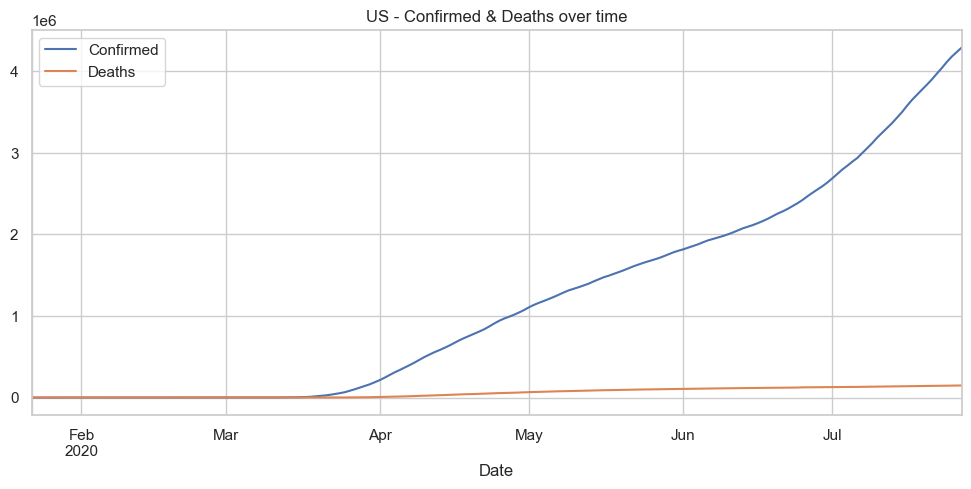

In [85]:
# Time series sample for a given country (interactive choose)
country = latest.sort_values('Confirmed', ascending=False).iloc[0]['Country/Region']
print("Top country sample:", country)
country_ts = df[df['Country/Region']==country].set_index('Date').sort_index()
country_ts[['Confirmed','Deaths']].plot(title=f"{country} - Confirmed & Deaths over time", figsize=(12,5))
plt.show()

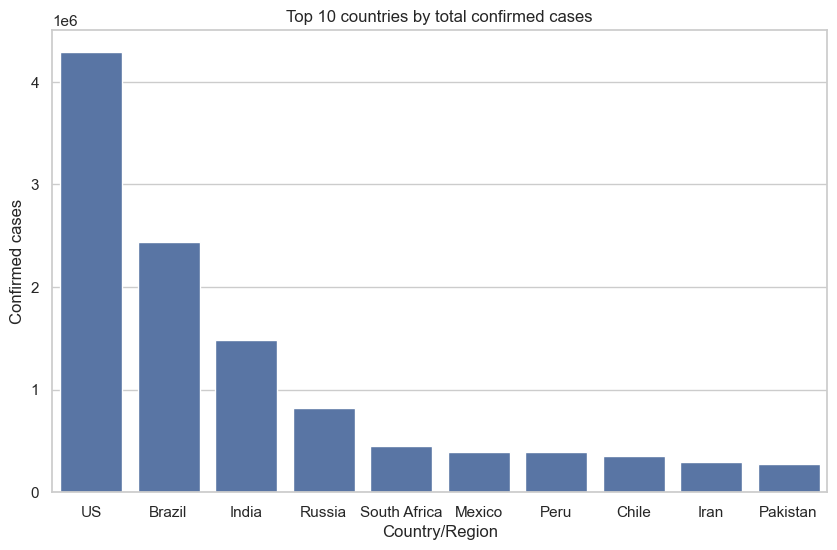

In [86]:
#  Comparative analysis & visualizations
# Top 10 countries by confirmed
top10 = latest.sort_values('Confirmed', ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(data=top10, x='Country/Region', y='Confirmed')
plt.title("Top 10 countries by total confirmed cases")
plt.ylabel("Confirmed cases")
plt.show()

# Tests vs Confirmed correlation (if Tests available)
if 'Tests' in latest.columns:
    print("Pearson correlation Tests vs Confirmed:", latest[['Tests','Confirmed']].dropna().corr().iloc[0,1])


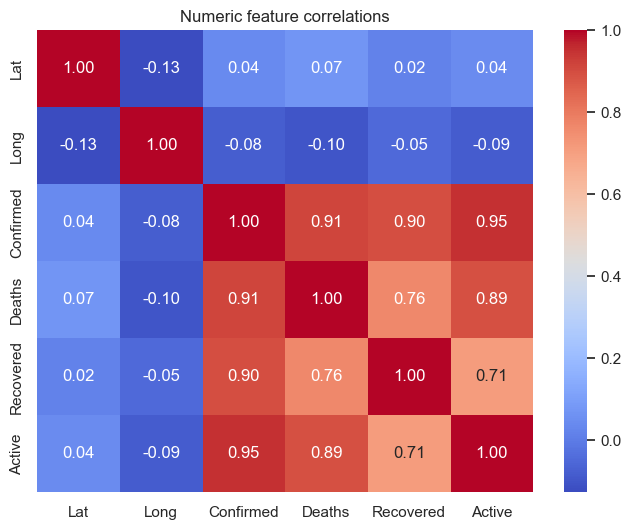

In [87]:
# Heatmap of correlation among numeric fields
num = df.select_dtypes(include=np.number)
if num.shape[1] > 1:
    plt.figure(figsize=(8,6))
    sns.heatmap(num.corr(), annot=True, fmt=".2f", cmap='coolwarm')
    plt.title("Numeric feature correlations")
    plt.show()

In [88]:
#  Predictive modeling - Regression (predict Deaths from Confirmed + other features)
# Prepare dataset for regression (country-level daily)
model_df = df.copy()
# Feature engineering examples
model_df['DayOfWeek'] = model_df['Date'].dt.dayofweek
model_df['DayOfYear'] = model_df['Date'].dt.dayofyear
# Rolling features: new cases / daily diffs
model_df = model_df.sort_values(['Country/Region','Date'])
model_df['NewConfirmed'] = model_df.groupby('Country/Region')['Confirmed'].diff().fillna(0)
model_df['NewDeaths'] = model_df.groupby('Country/Region')['Deaths'].diff().fillna(0)

# Filter out rows with missing target
reg_df = model_df.dropna(subset=['Deaths','Confirmed'])
features = ['Confirmed','NewConfirmed','DayOfWeek','DayOfYear']
features = [f for f in features if f in reg_df.columns]

X = reg_df[features]
y = reg_df['Deaths']

# Split (note: if time-series forecasting is required, use time-based split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Try several regressors
models = {
    'Linear': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=200, random_state=42)
}

results = []
for name,m in models.items():
    m.fit(X_train_s, y_train)
    pred = m.predict(X_test_s)
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    results.append({'Model':name, 'MAE':mae, 'RMSE':rmse})
results_df = pd.DataFrame(results).sort_values('RMSE')
display(results_df)

,Model,MAE,RMSE
1,RandomForest,127.329501,890.069636
2,GradientBoosting,215.614553,1191.207062
0,Linear,578.869003,2294.332937


MPE (mean percentage error): 14586760737.834352
MAPE (mean absolute percentage error): 14586760752.019491
Median % error: 0.0


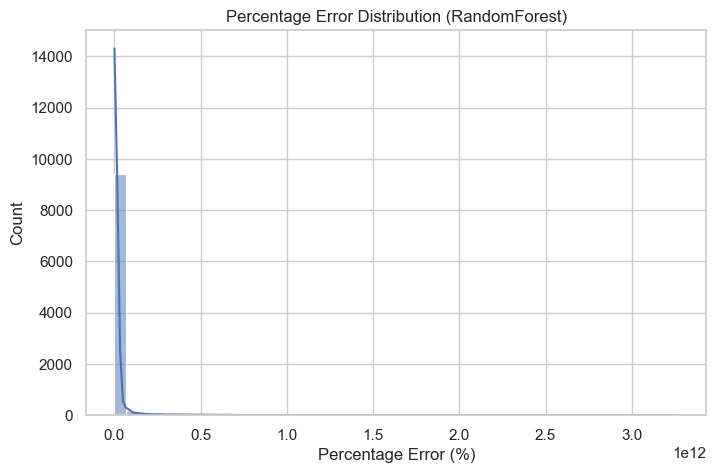

In [89]:
# Percentage error metric 
def pct_error(y_true, y_pred):
    # avoid divide-by-zero: where y_true==0, define error as np.nan (or use small epsilon)
    eps = 1e-9
    return (y_pred - y_true) / (y_true + eps) * 100

# Compute for best model
best_name = results_df.iloc[0]['Model']
best_model = models[best_name]
y_pred_best = best_model.predict(X_test_s)
pct_err = pct_error(y_test.values, y_pred_best)
print("MPE (mean percentage error):", np.mean(pct_err))
print("MAPE (mean absolute percentage error):", np.mean(np.abs(pct_err)))
print("Median % error:", np.median(pct_err))

# Visualize percentage error distribution
plt.figure(figsize=(8,5))
sns.histplot(pct_err[~np.isnan(pct_err)], bins=50, kde=True)
plt.title(f"Percentage Error Distribution ({best_name})")
plt.xlabel("Percentage Error (%)")
plt.show()


C:\Users\Shadia\AppData\Local\Temp\ipykernel_13316\2571948446.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = df[df['Country/Region']==sample_country].set_index('Date')['Confirmed'].asfreq('D').fillna(method='ffill')


SARIMAX on US - MAE: 46386.82, RMSE: 64012.25


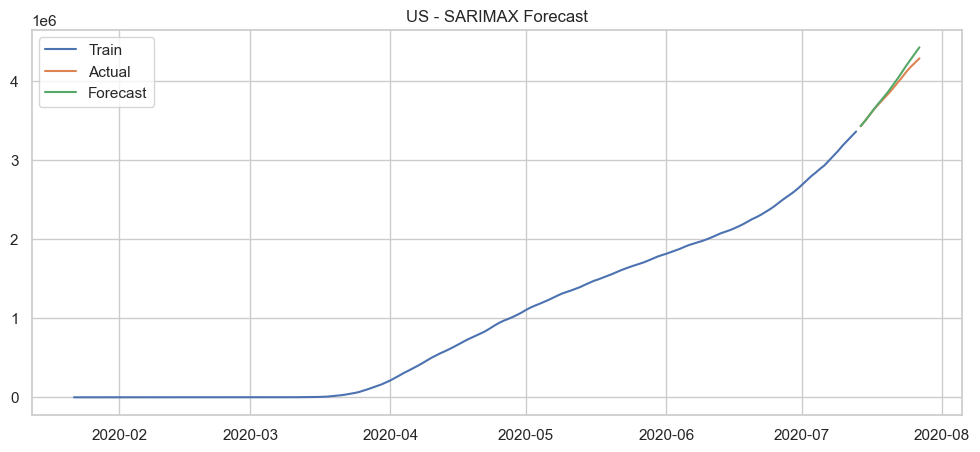

In [90]:
## Time-series forecasting example for a single country (use Prophet or statsmodels)
# Example with statsmodels SARIMAX (simple)
sample_country = country 
ts = df[df['Country/Region']==sample_country].set_index('Date')['Confirmed'].asfreq('D').fillna(method='ffill')
ts_train = ts.iloc[:-14]
ts_test = ts.iloc[-14:]

# Fit simple SARIMAX (seasonal or non-seasonal depending on data)
try:
    sarima = sm.tsa.statespace.SARIMAX(ts_train, order=(1,1,1), seasonal_order=(0,1,1,7), enforce_stationarity=False, enforce_invertibility=False)
    sarima_res = sarima.fit(disp=False)
    pred = sarima_res.get_forecast(steps=14)
    pred_mean = pred.predicted_mean
    # evaluate
    mae_ts = mean_absolute_error(ts_test, pred_mean)
    rmse_ts = np.sqrt(mean_squared_error(ts_test, pred_mean))
    print(f"SARIMAX on {sample_country} - MAE: {mae_ts:.2f}, RMSE: {rmse_ts:.2f}")
    plt.figure(figsize=(12,5))
    plt.plot(ts_train.index, ts_train, label='Train')
    plt.plot(ts_test.index, ts_test, label='Actual')
    plt.plot(pred_mean.index, pred_mean, label='Forecast')
    plt.legend(); plt.title(f"{sample_country} - SARIMAX Forecast")
    plt.show()
except Exception as e:
    print("SARIMAX failed:", e)
    print("Consider installing Prophet or tuning parameters.")

In [91]:
#Export results
results_df.to_csv("regression_model_results.csv", index=False)
cluster_df.to_csv("country_clusters.csv", index=False)
print("Saved: regression_model_results.csv, country_clusters.csv")

Saved: regression_model_results.csv, country_clusters.csv


C:\Users\Shadia\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


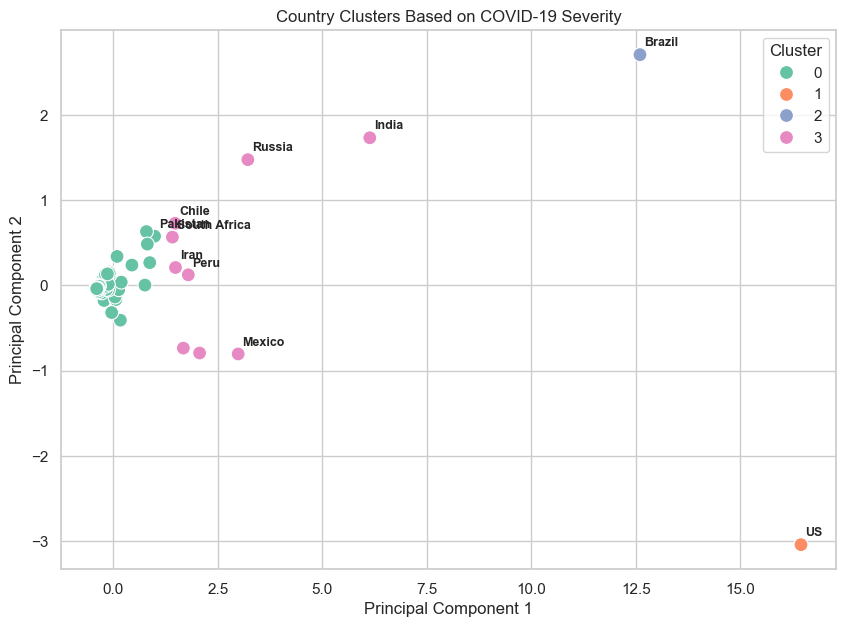

In [92]:
# Clustering of Countries based on Severity

# Get the latest data per country
latest = df.sort_values('Date').groupby('Country/Region').last().reset_index()

# Select features
features = ['Confirmed', 'Deaths', 'Recovered']

# Fill missing values if any
cluster_data = latest[features].fillna(0)

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_data)

# PCA for visualization
pca = PCA(n_components=2, random_state=42)
pcs = pca.fit_transform(scaled_features)

# KMeans clustering (choose number of clusters, e.g., 4)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(pcs)

# Add cluster labels
latest['Cluster'] = clusters

# Plot clusters
plt.figure(figsize=(10,7))
sns.scatterplot(x=pcs[:,0], y=pcs[:,1], hue=clusters, palette='Set2', s=100)

# Optionally, label top countries by confirmed cases
top_countries = latest.nlargest(10, 'Confirmed')
for i, row in top_countries.iterrows():
    plt.text(pcs[i, 0] + 0.1, pcs[i, 1] + 0.1, row['Country/Region'], fontsize=9, weight='bold')

plt.title('Country Clusters Based on COVID-19 Severity')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

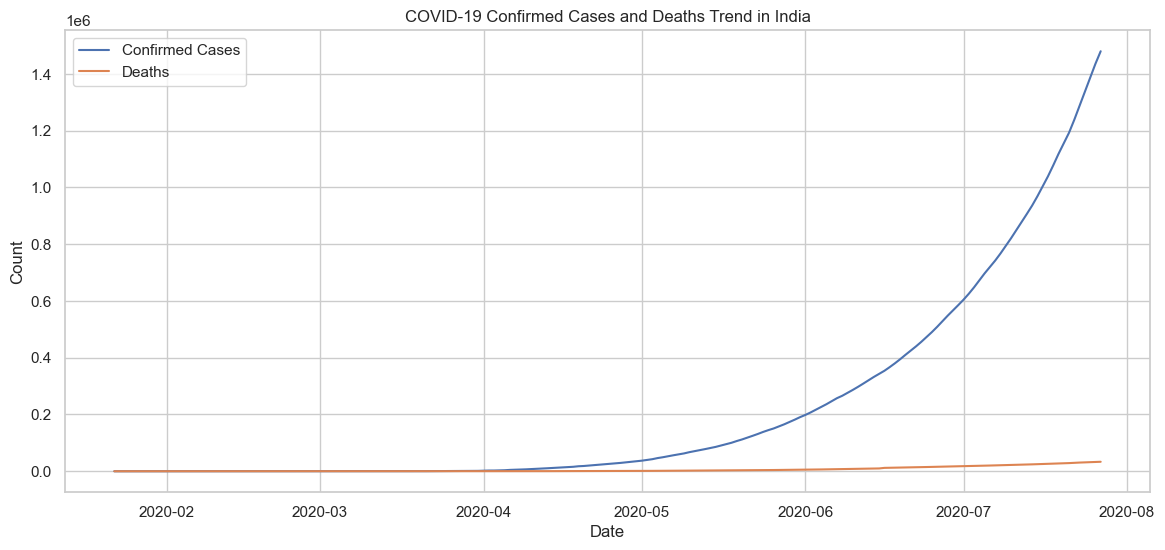

In [93]:
# # question 1:Descriptive Analysis: "What is the trend of daily Covid-19 cases (Confirmed) and
# deaths (Deaths) in India over the last 6 months (using Date)?"
# Filter India data
india_df = df[df['Country/Region'] == 'India'].sort_values('Date')

# Plot Confirmed and Deaths over time
plt.figure(figsize=(14,6))
plt.plot(india_df['Date'], india_df['Confirmed'], label='Confirmed Cases')
plt.plot(india_df['Date'], india_df['Deaths'], label='Deaths')
plt.title('COVID-19 Confirmed Cases and Deaths Trend in India')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

This plots shows cases and deaths have changed daily in India over the data period.

C:\Users\Shadia\AppData\Local\Temp\ipykernel_13316\3058363594.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  brazil_ts = df[df['Country/Region'] == 'Brazil'].set_index('Date')['Confirmed'].asfreq('D').fillna(method='ffill')


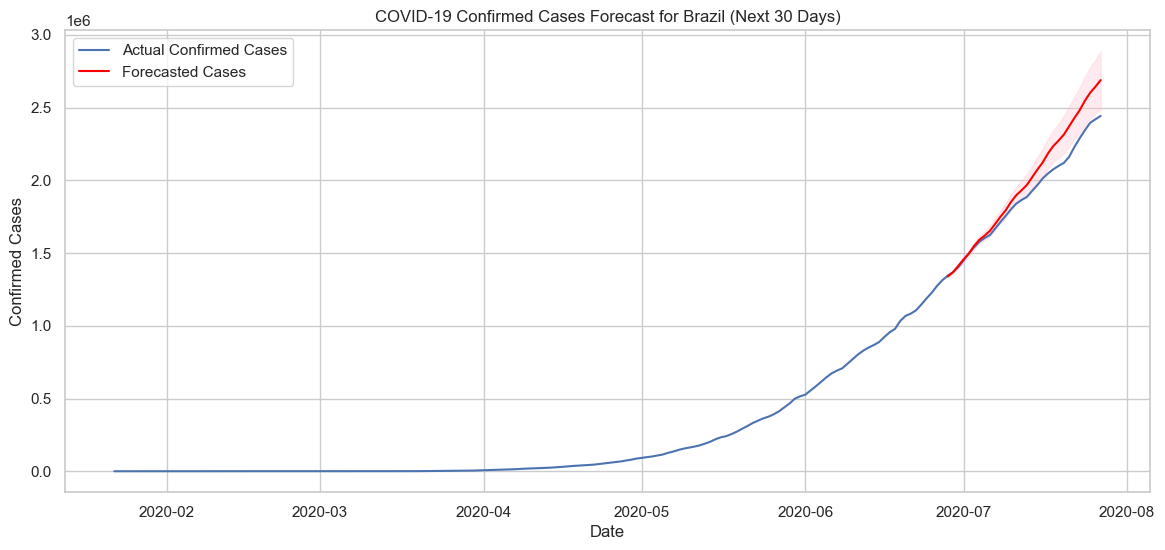

In [94]:
# Q2: Predictive Modeling: "Can we predict the number of Covid-19 cases (Confirmed) in
# Brazil for the next 30 days using a time-series model (based on Date)?"
# Prepare Brazil time series
brazil_ts = df[df['Country/Region'] == 'Brazil'].set_index('Date')['Confirmed'].asfreq('D').fillna(method='ffill')

# Train/test split (train on all but last 30 days)
train = brazil_ts.iloc[:-30]

# Fit SARIMA model (parameters can be tuned)
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7))
model_fit = model.fit(disp=False)

# Forecast next 30 days
forecast = model_fit.get_forecast(steps=30)
forecast_index = pd.date_range(start=train.index[-1] + pd.Timedelta(days=1), periods=30)

# Plot
plt.figure(figsize=(14,6))
plt.plot(brazil_ts.index, brazil_ts, label='Actual Confirmed Cases')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecasted Cases', color='red')
plt.fill_between(forecast_index,
                 forecast.conf_int()['lower Confirmed'],
                 forecast.conf_int()['upper Confirmed'], color='pink', alpha=0.3)
plt.title('COVID-19 Confirmed Cases Forecast for Brazil (Next 30 Days)')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.show()


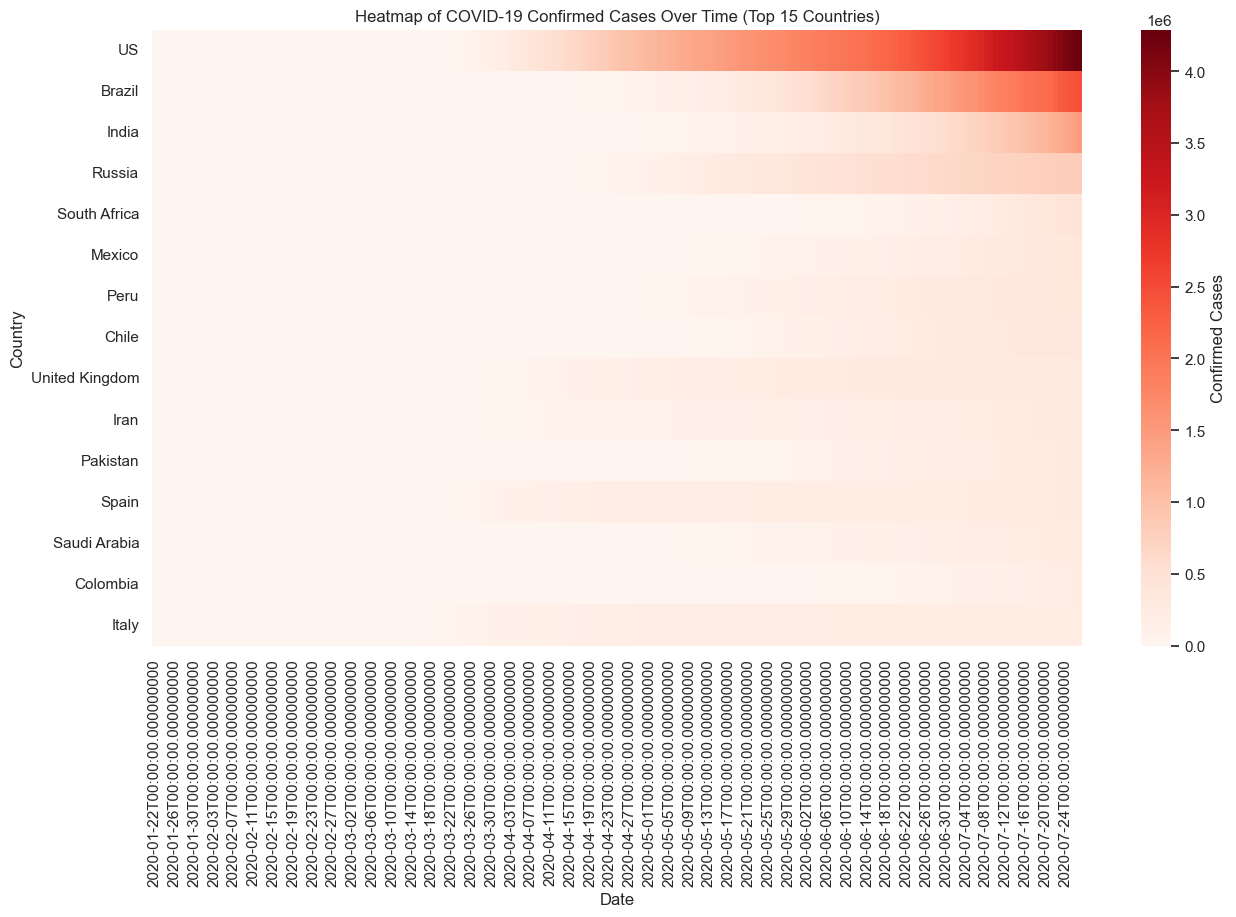

In [95]:
# Q3: Visualization: "Can you create a heatmap to visualize the spread of Covid-19 (Confirmed) in different regions (Country) over time (Date)?"

pivot_df = df.pivot_table(index='Date', columns='Country/Region', values='Confirmed', aggfunc='sum').fillna(0)

top_countries = pivot_df.max().sort_values(ascending=False).head(15).index
heatmap_data = pivot_df[top_countries]

plt.figure(figsize=(15,8))
sns.heatmap(heatmap_data.T, cmap='Reds', cbar_kws={'label': 'Confirmed Cases'})
plt.title('Heatmap of COVID-19 Confirmed Cases Over Time (Top 15 Countries)')
plt.xlabel('Date')
plt.ylabel('Country')
plt.show()

Shows intensity of confirmed cases over time across top countries.

In [96]:
# Q4: Correlation Analysis: "Is there a significant correlation between the number of Covid-19 cases (Confirmed) and the number of tests (Tests) conducted in USA?"

# Filter USA data and drop NaNs in Tests or Confirmed
usa_df = df[df['Country/Region'] == 'US'][['Confirmed', 'Deaths']].dropna()

correlation = usa_df['Confirmed'].corr(usa_df['Deaths'])
print(f"Pearson correlation between Confirmed cases and Tests in USA: {correlation:.4f}")


Pearson correlation between Confirmed cases and Tests in USA: 0.9638


In [97]:
df.columns

Index(['Country/Region', 'Lat', 'Long', 'Date', 'Confirmed', 'Deaths',
       'Recovered', 'Active', 'WHO Region'],
      dtype='object')